In [1]:
import numpy as np
from scipy.optimize import minimize_scalar
import matplotlib.pyplot as plt
import time

### Parse the Graphs

In [2]:
def load_dimacs_graph(filepath):
    with open(filepath, 'r') as f:
        lines = f.readlines()

    nodes = 0
    edges = []
    
    for line in lines:
        if line.startswith('p'):
            parts = line.strip().split()
            nodes = int(parts[2])
        elif line.startswith('e'):
            parts = line.strip().split()
            i, j = int(parts[1]) - 1, int(parts[2]) - 1  # 0-based indexing
            edges.append((i, j))
    
    W = np.zeros((nodes, nodes))
    for i, j in edges:
        W[i, j] = 1
        W[j, i] = 1  # since the graph is undirected
    return W

In [3]:
A1 = load_dimacs_graph("graphs/C125.9.clq")
A2 = load_dimacs_graph("graphs/C250.9.clq")
A3 = load_dimacs_graph("graphs/keller4.clq")
alpha = 0.5

print(A1.shape)
A1

(125, 125)


array([[0., 1., 1., ..., 1., 1., 1.],
       [1., 0., 0., ..., 1., 1., 1.],
       [1., 0., 0., ..., 1., 1., 1.],
       ...,
       [1., 1., 1., ..., 0., 1., 1.],
       [1., 1., 1., ..., 1., 0., 1.],
       [1., 1., 1., ..., 1., 1., 0.]])

### Objective Functions

In [4]:
# equation 31
def obj_l2(x, A, alpha = 0.5):
    return x.T @ A @ x + alpha * (x @ x)

def grad_l2(x, A, alpha = 0.5):
    return 2 * A @ x + alpha * 2 * x

# equation 33
def obj_l0(x, A, alpha=0.07, beta=5):
    val = x.T @ (A @ x)
    return float(val) + alpha * np.sum(np.exp(-beta * x) - 1)

def grad_l0(x, A, alpha=0.07, beta=5):
    return 2 * (A @ x) - alpha * beta * np.exp(-beta * x)

### Utility Functions

In [5]:
def LMO(gradient):
    i = np.argmin(gradient)
    s_fw = np.zeros_like(gradient)
    s_fw[i] = 1.0
    return s_fw, i

def degree_based_initialization(A):
    n = A.shape[0]
    degrees = A.sum(axis=1)
    x_init = degrees / degrees.sum()
    return x_init

def degree_random_initialization(A, eps=1e-2, rng=None):
    if rng is None:
        rng = np.random.default_rng()
    n = A.shape[0]
    degrees = A.sum(axis=1).astype(float)
    x = degrees / degrees.sum()
    x += eps * rng.random(n)
    x /= x.sum()
    return x

def exact_line_search(func, x, direction, max_step=1.0):
    if max_step <= 1e-12:
        return 0.0
    phi = lambda gamma: -func(x + gamma * direction)
    res = minimize_scalar(phi, bounds=(0, max_step), method='bounded')
    if res.success:
        return res.x
    return 0.0

def armijo_line_search(func, x, gradient, direction, A_matrix, initial_step=1.0, c1=0.1, tau=0.5, max_iter=100):
    cur_val = func(x, A_matrix)
    step = initial_step
    grad_dot_dir = np.dot(gradient, direction)
    
    for _ in range(max_iter):
        x_new = x + step * direction
        new_val = func(x_new, A_matrix)
        if new_val >= cur_val + c1 * step * grad_dot_dir:
            return step
        step *= tau
    return 0.0


def away_step_vertex(x, gradient, tol=1e-12):
    active_set = np.where(x > tol)[0]
    if active_set.size == 0:
        raise ValueError("Active set is empty.")
    worst_idx = active_set[np.argmax(gradient[active_set])]
    v = np.zeros_like(x)
    v[worst_idx] = 1.0
    return v, worst_idx

def log_adaptive_step_size(t):
    return (2 + np.log(t + 1)) / (t + 2 + np.log(t + 1))


In [6]:
def extract_clique_from_solution(x, W, threshold=0.01):
    candidates = np.argsort(-x)
    clique = []

    for i in candidates:
        if x[i] < threshold:
            break
        if all(W[i, j] == 1 for j in clique):
            clique.append(i)

    return clique, len(clique)

### Frank-Wolfe Algorithm

In [7]:
def frank_wolfe(obj_func, grad_obj_func, A, num_iters, line_search=None, tol=1e-6, verbose=True):
    n = A.shape[0]
    #x = np.ones(n) / n
    x = degree_based_initialization(A)

    history = [obj_func(x, A)]
    opt_x = x.copy()
    best_func = history[0]

    for iter in range(1, num_iters+1):
        grad = grad_obj_func(x, A)
        vertex, _ = LMO(-grad)
        direction = vertex - x

        # Step size strategy
        if line_search =='exact':
            step = exact_line_search(lambda z: obj_func(z, A), x, direction, max_step=1.0)
        elif line_search == 'armijo':
            step = armijo_line_search(obj_func, x, grad, direction, A, initial_step = 1.0)
        elif line_search == 'demin':
            step = min(2 / (iter + 1), 1.0)
        elif line_search == 'log':
            step = log_adaptive_step_size(iter + 1)

        # Update
        x += step * direction
        cur_func = obj_func(x, A)
        history.append(cur_func)

        if cur_func > best_func:
            best_func = cur_func
            opt_x = x
        
        # added better condition for optimization problems with objectives that can vary widely in magnitude
        if abs(cur_func - history[-2]) / max(1, abs(history[-2])) < tol:
            print(f"Converged at iteration {iter+1}, relative update = {cur_func - history[-2]:.2e}")
            break

        if verbose and iter % 10 == 0:
                print(f"Iter {iter+1:3d}: f(x) = {cur_func:.6f}, step = {step:.4f}")

    return opt_x, history

### FW on l2-regularized objective function

In [8]:
# FW with exact line search
x_opt_FW_exact_l2_A1, history_FW_exact_l2_A1 = frank_wolfe(obj_l2, grad_l2, A1, num_iters=1000, line_search= 'exact')
clique_FW_exact_l2_A1, size_clique_FW_exact_l2_A1 = extract_clique_from_solution(x_opt_FW_exact_l2_A1, A1)
print(f'Extracted Max Clique is of size: {size_clique_FW_exact_l2_A1}.')

Iter  11: f(x) = 0.939571, step = 0.0688
Iter  21: f(x) = 0.957277, step = 0.0497
Iter  31: f(x) = 0.966552, step = 0.0356
Iter  41: f(x) = 0.971225, step = 0.0262
Iter  51: f(x) = 0.973770, step = 0.0202
Iter  61: f(x) = 0.975394, step = 0.0167
Iter  71: f(x) = 0.976542, step = 0.0142
Iter  81: f(x) = 0.977395, step = 0.0124
Iter  91: f(x) = 0.978056, step = 0.0110
Iter 101: f(x) = 0.978583, step = 0.0099
Iter 111: f(x) = 0.979014, step = 0.0090
Iter 121: f(x) = 0.979372, step = 0.0082
Iter 131: f(x) = 0.979675, step = 0.0076
Iter 141: f(x) = 0.979935, step = 0.0071
Iter 151: f(x) = 0.980161, step = 0.0066
Iter 161: f(x) = 0.980358, step = 0.0062
Iter 171: f(x) = 0.980532, step = 0.0058
Iter 181: f(x) = 0.980686, step = 0.0055
Iter 191: f(x) = 0.980825, step = 0.0052
Iter 201: f(x) = 0.980949, step = 0.0049
Iter 211: f(x) = 0.981062, step = 0.0047
Iter 221: f(x) = 0.981165, step = 0.0045
Iter 231: f(x) = 0.981258, step = 0.0043
Iter 241: f(x) = 0.981344, step = 0.0041
Iter 251: f(x) =

In [9]:
# FW with Armijo line search
x_opt_FW_armijo_l2_A1, history_FW_armijo_l2_A1 = frank_wolfe(obj_l2, grad_l2, A1, num_iters=1000, line_search= 'armijo')
clique_FW_armijo_l2_A1, size_clique_FW_armijo_l2_A1 = extract_clique_from_solution(x_opt_FW_armijo_l2_A1, A1)
print(f'Extracted Max Clique is of size: {size_clique_FW_armijo_l2_A1}.')

Iter  11: f(x) = 0.939897, step = 0.1250
Iter  21: f(x) = 0.957038, step = 0.1250
Iter  31: f(x) = 0.972828, step = 0.0625
Iter  41: f(x) = 0.978152, step = 0.0312
Iter  51: f(x) = 0.980500, step = 0.0312
Iter  61: f(x) = 0.981507, step = 0.0156
Iter  71: f(x) = 0.981978, step = 0.0156
Iter  81: f(x) = 0.982212, step = 0.0078
Iter  91: f(x) = 0.982302, step = 0.0078
Iter 101: f(x) = 0.982370, step = 0.0078
Iter 111: f(x) = 0.982442, step = 0.0078
Iter 121: f(x) = 0.982502, step = 0.0078
Iter 131: f(x) = 0.982556, step = 0.0078
Iter 141: f(x) = 0.982613, step = 0.0078
Iter 151: f(x) = 0.982660, step = 0.0078
Iter 161: f(x) = 0.982732, step = 0.0039
Iter 171: f(x) = 0.982764, step = 0.0039
Iter 181: f(x) = 0.982784, step = 0.0039
Iter 191: f(x) = 0.982805, step = 0.0039
Iter 201: f(x) = 0.982825, step = 0.0039
Iter 211: f(x) = 0.982842, step = 0.0039
Iter 221: f(x) = 0.982861, step = 0.0039
Iter 231: f(x) = 0.982879, step = 0.0039
Iter 241: f(x) = 0.982895, step = 0.0039
Iter 251: f(x) =

In [10]:
# FW with One-Loop line search
x_opt_FW_log_l2_A1, history_FW_log_l2_A1 = frank_wolfe(obj_l2, grad_l2, A1, num_iters=1000, line_search='log')
clique_FW_log_l2_A1, size_clique_FW_log_l2_A1 = extract_clique_from_solution(x_opt_FW_log_l2_A1, A1)
print(f'Extracted Max Clique is of size: {size_clique_FW_log_l2_A1}.')


Iter  11: f(x) = 0.908864, step = 0.2896
Iter  21: f(x) = 0.942072, step = 0.1951
Iter  31: f(x) = 0.956643, step = 0.1499
Iter  41: f(x) = 0.964767, step = 0.1228
Iter  51: f(x) = 0.969663, step = 0.1045
Iter  61: f(x) = 0.972808, step = 0.0913
Iter  71: f(x) = 0.974955, step = 0.0812
Iter  81: f(x) = 0.976491, step = 0.0733
Iter  91: f(x) = 0.977628, step = 0.0669
Iter 101: f(x) = 0.978495, step = 0.0616
Iter 111: f(x) = 0.979172, step = 0.0571
Iter 121: f(x) = 0.979712, step = 0.0532
Iter 131: f(x) = 0.980150, step = 0.0499
Iter 141: f(x) = 0.980510, step = 0.0470
Iter 151: f(x) = 0.980811, step = 0.0444
Iter 161: f(x) = 0.981064, step = 0.0422
Iter 171: f(x) = 0.981279, step = 0.0401
Iter 181: f(x) = 0.981465, step = 0.0383
Iter 191: f(x) = 0.981625, step = 0.0366
Iter 201: f(x) = 0.981765, step = 0.0351
Iter 211: f(x) = 0.981887, step = 0.0337
Iter 221: f(x) = 0.981996, step = 0.0324
Iter 231: f(x) = 0.982092, step = 0.0312
Iter 241: f(x) = 0.982178, step = 0.0301
Iter 251: f(x) =

### FW on l0-regularized objective function

In [11]:
# FW with Armijo line search
x_opt_FW_armijo_l0_A1, history_FW_armijo_l0_A1 = frank_wolfe(obj_l0, grad_l0, A1, num_iters=1000, line_search= 'armijo')
clique_FW_armijo_l0_A1, size_clique_FW_armijo_l0_A1 = extract_clique_from_solution(x_opt_FW_armijo_l0_A1, A1)
print(f'Extracted Max Clique is of size: {size_clique_FW_armijo_l0_A1}.')


Iter  11: f(x) = 0.606562, step = 0.1250
Iter  21: f(x) = 0.624054, step = 0.1250
Iter  31: f(x) = 0.636294, step = 0.0625
Iter  41: f(x) = 0.640071, step = 0.0625
Iter  51: f(x) = 0.641934, step = 0.0312
Iter  61: f(x) = 0.642600, step = 0.0312
Iter  71: f(x) = 0.643121, step = 0.0156
Iter  81: f(x) = 0.643346, step = 0.0156
Iter  91: f(x) = 0.643499, step = 0.0078
Iter 101: f(x) = 0.643564, step = 0.0078
Iter 111: f(x) = 0.643607, step = 0.0078
Iter 121: f(x) = 0.643663, step = 0.0078
Iter 131: f(x) = 0.643705, step = 0.0078
Iter 141: f(x) = 0.643739, step = 0.0078
Iter 151: f(x) = 0.643783, step = 0.0078
Iter 161: f(x) = 0.643817, step = 0.0078
Iter 171: f(x) = 0.643844, step = 0.0078
Iter 181: f(x) = 0.643878, step = 0.0078
Iter 191: f(x) = 0.643908, step = 0.0039
Iter 201: f(x) = 0.643943, step = 0.0039
Converged at iteration 208, relative update = 9.92e-07
Extracted Max Clique is of size: 30.


In [12]:
# FW with Deminishing step size
x_opt_FW_demin_l0_A1, history_FW_demin_l0_A1 = frank_wolfe(obj_l0, grad_l0, A1, num_iters=1000, line_search= 'demin')
clique_FW_demin_l0_A1, size_clique_FW_demin_l0_A1 = extract_clique_from_solution(x_opt_FW_demin_l0_A1, A1)
print(f'Extracted Max Clique is of size: {size_clique_FW_demin_l0_A1}.')

Iter  11: f(x) = 0.611919, step = 0.1818
Iter  21: f(x) = 0.635547, step = 0.0952
Iter  31: f(x) = 0.640894, step = 0.0645
Iter  41: f(x) = 0.641543, step = 0.0488
Iter  51: f(x) = 0.642143, step = 0.0392
Iter  61: f(x) = 0.642509, step = 0.0328
Iter  71: f(x) = 0.642614, step = 0.0282
Iter  81: f(x) = 0.642780, step = 0.0247
Iter  91: f(x) = 0.642840, step = 0.0220
Iter 101: f(x) = 0.642886, step = 0.0198
Iter 111: f(x) = 0.642946, step = 0.0180
Iter 121: f(x) = 0.642964, step = 0.0165
Iter 131: f(x) = 0.642995, step = 0.0153
Converged at iteration 141, relative update = 9.38e-07
Extracted Max Clique is of size: 26.


In [13]:
# FW with One-Loop line search
x_opt_FW_log_l0_A1, history_FW_log_l0_A1 = frank_wolfe(obj_l0, grad_l0, A1, num_iters=1000, line_search= 'log')
clique_FW_log_l0_A1, size_clique_FW_log_l0_A1 = extract_clique_from_solution(x_opt_FW_log_l0_A1, A1)
print(f'Extracted Max Clique is of size: {size_clique_FW_log_l0_A1}.')

Iter  11: f(x) = 0.581792, step = 0.2896
Iter  21: f(x) = 0.615118, step = 0.1951
Iter  31: f(x) = 0.627162, step = 0.1499
Iter  41: f(x) = 0.633056, step = 0.1228
Iter  51: f(x) = 0.636318, step = 0.1045
Iter  61: f(x) = 0.638300, step = 0.0913
Iter  71: f(x) = 0.639602, step = 0.0812
Iter  81: f(x) = 0.640508, step = 0.0733
Iter  91: f(x) = 0.641165, step = 0.0669
Iter 101: f(x) = 0.641657, step = 0.0616
Iter 111: f(x) = 0.642038, step = 0.0571
Iter 121: f(x) = 0.642338, step = 0.0532
Iter 131: f(x) = 0.642579, step = 0.0499
Iter 141: f(x) = 0.642776, step = 0.0470
Iter 151: f(x) = 0.642939, step = 0.0444
Iter 161: f(x) = 0.643076, step = 0.0422
Iter 171: f(x) = 0.643193, step = 0.0401
Iter 181: f(x) = 0.643292, step = 0.0383
Iter 191: f(x) = 0.643378, step = 0.0366
Iter 201: f(x) = 0.643453, step = 0.0351
Iter 211: f(x) = 0.643518, step = 0.0337
Iter 221: f(x) = 0.643576, step = 0.0324
Iter 231: f(x) = 0.643627, step = 0.0312
Iter 241: f(x) = 0.643672, step = 0.0301
Iter 251: f(x) =

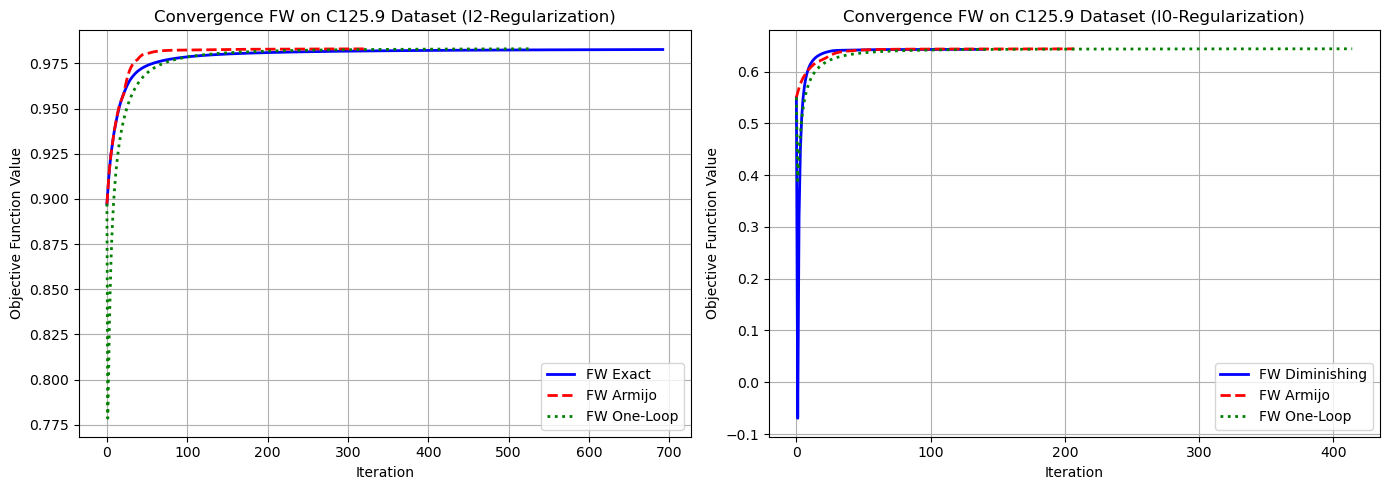

In [14]:
def plot_fw_results(
    history_FW_exact_l2_A1, history_FW_armijo_l2_A1, history_FW_log_l2_A1,
    history_FW_armijo_l0_A1, history_FW_demin_l0_A1, history_FW_log_l0_A1, graph_name = None
):
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # --- First subplot: l2-Regularization ---
    axes[0].plot(history_FW_exact_l2_A1, label='FW Exact', color='blue', linewidth=2, linestyle='-')
    axes[0].plot(history_FW_armijo_l2_A1, label='FW Armijo', color='red', linewidth=2, linestyle='--')
    axes[0].plot(history_FW_log_l2_A1, label='FW One-Loop', color='green', linewidth=2, linestyle=':')
    axes[0].set_xlabel("Iteration")
    axes[0].set_ylabel("Objective Function Value")
    axes[0].set_title(f"Convergence FW on {graph_name} Dataset (l2-Regularization)")
    axes[0].legend()
    axes[0].grid(True)

    # --- Second subplot: l0-Regularization ---
    axes[1].plot(history_FW_demin_l0_A1, label='FW Diminishing', color='blue', linewidth=2, linestyle='-')
    axes[1].plot(history_FW_armijo_l0_A1, label='FW Armijo', color='red', linewidth=2, linestyle='--')
    axes[1].plot(history_FW_log_l0_A1, label='FW One-Loop', color='green', linewidth=2, linestyle=':')
    axes[1].set_xlabel("Iteration")
    axes[1].set_ylabel("Objective Function Value")
    axes[1].set_title(f"Convergence FW on {graph_name} Dataset (l0-Regularization)")
    axes[1].legend()
    axes[1].grid(True)

    plt.tight_layout()
    plt.show()

plot_fw_results(
    history_FW_exact_l2_A1, history_FW_armijo_l2_A1, history_FW_log_l2_A1,
    history_FW_armijo_l0_A1, history_FW_demin_l0_A1, history_FW_log_l0_A1, graph_name='C125.9'
)

### Away Step FW Algorithm

In [15]:
def away_step_frank_wolfe(obj_func, grad_obj_func, A, num_iters, line_search=None, tol=1e-6, verbose=True):
    n = A.shape[0]
    #x = np.ones(n) / n
    x = degree_based_initialization(A)
    history = [obj_func(x, A)]
    opt_x = x.copy()
    best_func = history[0]

    for iter in range(1, num_iters + 1):
        grad = grad_obj_func(x, A)
        vertex_fw, _ = LMO(-grad)
        direction_fw = vertex_fw - x
        gap_fw = np.dot(-grad, direction_fw)

        vertex_as, v_idx = away_step_vertex(x, -grad)
        direction_as = x - vertex_as
        gap_as = np.dot(-grad, direction_as)

        if gap_fw >= gap_as or np.count_nonzero(x) == 1:
            direction = direction_fw
            max_step = 1.0
        else:
            direction = direction_as
            alpha = x[v_idx]
            max_step = alpha / (1 - alpha) if alpha < 1.0 else 1.0

        # Step size strategy
        if line_search =='exact':
            step = exact_line_search(lambda z: obj_func(z, A), x, direction, max_step=max_step)
        elif line_search == 'armijo':
            step = armijo_line_search(obj_func, x, grad, direction, A, initial_step = 1.0)
        elif line_search == 'demin':
            step = min(2 / (iter + 1), 1.0)
        elif line_search == 'log':
            step = log_adaptive_step_size(iter + 1)

        x += step * direction
        cur_func = obj_func(x, A)
        history.append(cur_func)

        if cur_func > best_func:
            best_func = cur_func
            opt_x = x.copy()

        if abs(cur_func - history[-2]) < tol:
            break

        if verbose and iter % 10 == 0:
            print(f"Iter {iter:3d}: f(x) = {cur_func:.6f}, step = {step:.4f}")

    return opt_x, history


### ASFW on l2-regularized objective function

In [16]:
# ASFW with exact line search
x_opt_ASFW_exact_l2_A1, history_ASFW_exact_l2_A1 = away_step_frank_wolfe(obj_l2, grad_l2, A1, num_iters=1000, line_search= 'exact')
clique_ASFW_exact_l2_A1, size_clique_ASFW_exact_l2_A1 = extract_clique_from_solution(x_opt_ASFW_exact_l2_A1, A1)
print(f'Extracted Max Clique is of size: {size_clique_ASFW_exact_l2_A1}.')


Iter  10: f(x) = 0.939571, step = 0.0688
Iter  20: f(x) = 0.957277, step = 0.0497
Iter  30: f(x) = 0.966552, step = 0.0356
Iter  40: f(x) = 0.971225, step = 0.0262
Iter  50: f(x) = 0.973770, step = 0.0202
Iter  60: f(x) = 0.975394, step = 0.0167
Iter  70: f(x) = 0.976542, step = 0.0142
Iter  80: f(x) = 0.977395, step = 0.0124
Iter  90: f(x) = 0.978056, step = 0.0110
Iter 100: f(x) = 0.978583, step = 0.0099
Iter 110: f(x) = 0.979014, step = 0.0090
Iter 120: f(x) = 0.979372, step = 0.0082
Iter 130: f(x) = 0.979675, step = 0.0076
Iter 140: f(x) = 0.979935, step = 0.0071
Iter 150: f(x) = 0.980161, step = 0.0066
Iter 160: f(x) = 0.980358, step = 0.0062
Iter 170: f(x) = 0.980532, step = 0.0058
Iter 180: f(x) = 0.980686, step = 0.0055
Iter 190: f(x) = 0.980825, step = 0.0052
Iter 200: f(x) = 0.980949, step = 0.0049
Iter 210: f(x) = 0.981062, step = 0.0047
Iter 220: f(x) = 0.981165, step = 0.0045
Iter 230: f(x) = 0.981258, step = 0.0043
Iter 240: f(x) = 0.981344, step = 0.0041
Iter 250: f(x) =

In [17]:
# ASFW with Armijo line search
x_opt_ASFW_armijo_l2_A1, history_ASFW_armijo_l2_A1 = away_step_frank_wolfe(obj_l2, grad_l2, A1, num_iters=1000, line_search='armijo')
clique_ASFW_armijo_l2_A1, size_clique_ASFW_armijo_l2_A1 = extract_clique_from_solution(x_opt_ASFW_armijo_l2_A1, A1)
print(f'Extracted Max Clique is of size: {size_clique_ASFW_armijo_l2_A1}.')

Iter  10: f(x) = 0.939897, step = 0.1250
Iter  20: f(x) = 0.957038, step = 0.1250
Iter  30: f(x) = 0.972828, step = 0.0625
Iter  40: f(x) = 0.978152, step = 0.0312
Iter  50: f(x) = 0.980500, step = 0.0312
Iter  60: f(x) = 0.981507, step = 0.0156
Iter  70: f(x) = 0.981978, step = 0.0156
Iter  80: f(x) = 0.982212, step = 0.0078
Iter  90: f(x) = 0.982302, step = 0.0078
Iter 100: f(x) = 0.982370, step = 0.0078
Iter 110: f(x) = 0.982442, step = 0.0078
Iter 120: f(x) = 0.982502, step = 0.0078
Iter 130: f(x) = 0.982556, step = 0.0078
Iter 140: f(x) = 0.982613, step = 0.0078
Iter 150: f(x) = 0.982660, step = 0.0078
Iter 160: f(x) = 0.982732, step = 0.0039
Iter 170: f(x) = 0.982764, step = 0.0039
Iter 180: f(x) = 0.982784, step = 0.0039
Iter 190: f(x) = 0.982805, step = 0.0039
Iter 200: f(x) = 0.982825, step = 0.0039
Iter 210: f(x) = 0.982842, step = 0.0039
Iter 220: f(x) = 0.982861, step = 0.0039
Iter 230: f(x) = 0.982879, step = 0.0039
Iter 240: f(x) = 0.982895, step = 0.0039
Iter 250: f(x) =

In [18]:
# ASFW with One-Loop line search
x_opt_ASFW_log_l2_A1, history_ASFW_log_l2_A1 = away_step_frank_wolfe(obj_l2, grad_l2, A1, num_iters=1000, line_search='log') 
clique_ASFW_log_l2_A1, size_clique_ASFW_log_l2_A1 = extract_clique_from_solution(x_opt_ASFW_log_l2_A1, A1)
print(f'Extracted Max Clique is of size: {size_clique_ASFW_log_l2_A1}.')

Iter  10: f(x) = 0.908864, step = 0.2896
Iter  20: f(x) = 0.942072, step = 0.1951
Iter  30: f(x) = 0.956643, step = 0.1499
Iter  40: f(x) = 0.964767, step = 0.1228
Iter  50: f(x) = 0.969663, step = 0.1045
Iter  60: f(x) = 0.972808, step = 0.0913
Iter  70: f(x) = 0.974955, step = 0.0812
Iter  80: f(x) = 0.976491, step = 0.0733
Iter  90: f(x) = 0.977628, step = 0.0669
Iter 100: f(x) = 0.978495, step = 0.0616
Iter 110: f(x) = 0.979172, step = 0.0571
Iter 120: f(x) = 0.979712, step = 0.0532
Iter 130: f(x) = 0.980150, step = 0.0499
Iter 140: f(x) = 0.980510, step = 0.0470
Iter 150: f(x) = 0.980811, step = 0.0444
Iter 160: f(x) = 0.981064, step = 0.0422
Iter 170: f(x) = 0.981279, step = 0.0401
Iter 180: f(x) = 0.981465, step = 0.0383
Iter 190: f(x) = 0.981625, step = 0.0366
Iter 200: f(x) = 0.981765, step = 0.0351
Iter 210: f(x) = 0.981887, step = 0.0337
Iter 220: f(x) = 0.981996, step = 0.0324
Iter 230: f(x) = 0.982092, step = 0.0312
Iter 240: f(x) = 0.982178, step = 0.0301
Iter 250: f(x) =

### ASFW on l0-regularized objective function

In [19]:
# ASFW with Armijo line search
x_opt_ASFW_armijo_l0_A1, history_ASFW_armijo_l0_A1 = away_step_frank_wolfe(obj_l0, grad_l0, A1, num_iters=1000, line_search='armijo')
clique_ASFW_armijo_l0_A1, size_clique_ASFW_armijo_l0_A1 = extract_clique_from_solution(x_opt_ASFW_armijo_l0_A1, A1)
print(f'Extracted Max Clique is of size: {size_clique_ASFW_armijo_l0_A1}.')

Iter  10: f(x) = 0.606562, step = 0.1250
Iter  20: f(x) = 0.624054, step = 0.1250
Iter  30: f(x) = 0.636294, step = 0.0625
Iter  40: f(x) = 0.640071, step = 0.0625
Iter  50: f(x) = 0.641934, step = 0.0312
Iter  60: f(x) = 0.642600, step = 0.0312
Iter  70: f(x) = 0.643121, step = 0.0156
Iter  80: f(x) = 0.643346, step = 0.0156
Iter  90: f(x) = 0.643499, step = 0.0078
Iter 100: f(x) = 0.643564, step = 0.0078
Iter 110: f(x) = 0.643607, step = 0.0078
Iter 120: f(x) = 0.643663, step = 0.0078
Iter 130: f(x) = 0.643705, step = 0.0078
Iter 140: f(x) = 0.643739, step = 0.0078
Iter 150: f(x) = 0.643783, step = 0.0078
Iter 160: f(x) = 0.643817, step = 0.0078
Iter 170: f(x) = 0.643844, step = 0.0078
Iter 180: f(x) = 0.643878, step = 0.0078
Iter 190: f(x) = 0.643908, step = 0.0039
Iter 200: f(x) = 0.643943, step = 0.0039
Extracted Max Clique is of size: 30.


In [20]:
# ASFW with One-Loop line search
x_opt_ASFW_log_l0_A1, history_ASFW_log_l0_A1 = away_step_frank_wolfe(obj_l0, grad_l0, A1, num_iters=1000, line_search='log')
clique_ASFW_log_l0_A1, size_clique_ASFW_log_l0_A1 = extract_clique_from_solution(x_opt_ASFW_log_l0_A1, A1)
print(f'Extracted Max Clique is of size: {size_clique_ASFW_log_l0_A1}.')

Iter  10: f(x) = 0.581792, step = 0.2896
Iter  20: f(x) = 0.615118, step = 0.1951
Iter  30: f(x) = 0.627162, step = 0.1499
Iter  40: f(x) = 0.633056, step = 0.1228
Iter  50: f(x) = 0.636318, step = 0.1045
Iter  60: f(x) = 0.638300, step = 0.0913
Iter  70: f(x) = 0.639602, step = 0.0812
Iter  80: f(x) = 0.640508, step = 0.0733
Iter  90: f(x) = 0.641165, step = 0.0669
Iter 100: f(x) = 0.641657, step = 0.0616
Iter 110: f(x) = 0.642038, step = 0.0571
Iter 120: f(x) = 0.642338, step = 0.0532
Iter 130: f(x) = 0.642579, step = 0.0499
Iter 140: f(x) = 0.642776, step = 0.0470
Iter 150: f(x) = 0.642939, step = 0.0444
Iter 160: f(x) = 0.643076, step = 0.0422
Iter 170: f(x) = 0.643193, step = 0.0401
Iter 180: f(x) = 0.643292, step = 0.0383
Iter 190: f(x) = 0.643378, step = 0.0366
Iter 200: f(x) = 0.643453, step = 0.0351
Iter 210: f(x) = 0.643518, step = 0.0337
Iter 220: f(x) = 0.643576, step = 0.0324
Iter 230: f(x) = 0.643627, step = 0.0312
Iter 240: f(x) = 0.643672, step = 0.0301
Iter 250: f(x) =

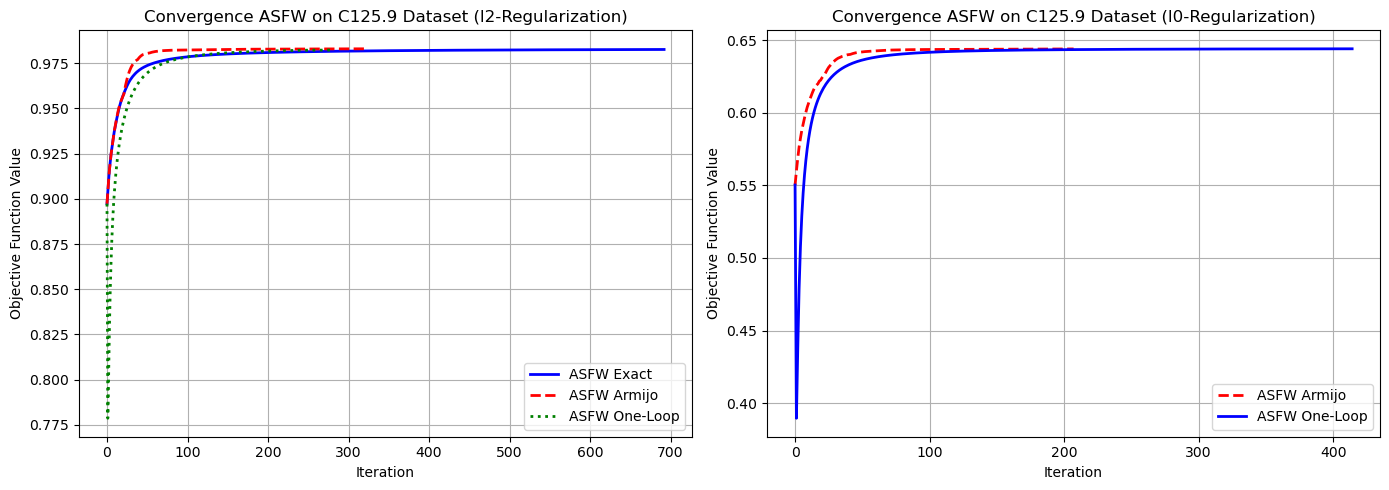

In [21]:
def plot_asfw_results(
    history_ASFW_exact_l2_A1, history_ASFW_armijo_l2_A1, history_ASFW_log_l2_A1,
    history_ASFW_armijo_l0_A1, history_ASFW_log_l0_A1, graph_name = None
):
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))  # 1 row, 2 columns

    # --- First subplot: l2-Regularization ---
    axes[0].plot(history_ASFW_exact_l2_A1, label='ASFW Exact', color='blue', linewidth=2, linestyle='-')
    axes[0].plot(history_ASFW_armijo_l2_A1, label='ASFW Armijo', color='red', linewidth=2, linestyle='--')
    axes[0].plot(history_ASFW_log_l2_A1, label='ASFW One-Loop', color='green', linewidth=2, linestyle=':')
    axes[0].set_xlabel("Iteration")
    axes[0].set_ylabel("Objective Function Value")
    axes[0].set_title(f"Convergence ASFW on {graph_name} Dataset (l2-Regularization)")
    axes[0].legend()
    axes[0].grid(True)

    # --- Second subplot: l0-Regularization ---
    axes[1].plot(history_ASFW_armijo_l0_A1, label='ASFW Armijo', color='red', linewidth=2, linestyle='--')
    axes[1].plot(history_ASFW_log_l0_A1, label='ASFW One-Loop', color='blue', linewidth=2, linestyle='-')
    axes[1].set_xlabel("Iteration")
    axes[1].set_ylabel("Objective Function Value")
    axes[1].set_title(f"Convergence ASFW on {graph_name} Dataset (l0-Regularization)")
    axes[1].legend()
    axes[1].grid(True)

    plt.tight_layout()
    plt.show()

plot_asfw_results(
    history_ASFW_exact_l2_A1, history_ASFW_armijo_l2_A1, history_ASFW_log_l2_A1,
    history_ASFW_armijo_l0_A1, history_ASFW_log_l0_A1, graph_name= 'C125.9'
)

### Pairwise Frank Wolfe

In [22]:
def pairwise_frank_wolfe(obj_func, grad_obj_func, A, num_iters, line_search=None, tol=1e-9, verbose=True, x_init=None):
    n = A.shape[0]
    x = np.ones(n) / n if x_init is None else x_init.copy()
    history = [obj_func(x, A)]
    opt_x = x.copy()
    best_func = history[0]

    for iter in range(1, num_iters +1):
        grad = grad_obj_func(x, A)
        vertex_fw, i_fw = LMO(-grad)
        vertex_as, i_as = away_step_vertex(x, -grad)

        if i_fw == i_as:
            if verbose:
                print(f"Stationary point reached at iter {iter}")
            break

        d = vertex_fw - vertex_as
        gamma_max = x[i_as]

        # Step size strategy
        if line_search =='exact':
            step = exact_line_search(lambda z: obj_func(z, A), x, d, max_step=1.0)
        elif line_search == 'armijo':
            step = armijo_line_search(obj_func, x, grad, d, A, initial_step = 1.0)
        elif line_search == 'demin':
            step = min(2 / (iter + 1), 1.0)
        elif line_search == 'log':
            step = log_adaptive_step_size(iter + 1)

        step = max(0.0, min(step, gamma_max))

        x[i_fw] += step
        x[i_as] -= step
        x = np.clip(x, 0.0, None)
        s = x.sum()
        if s <= 0:
            x = np.ones(n) / n
        else:
            x /= s

        cur = obj_func(x, A)
        history.append(cur)

        if cur > best_func:
            best_func = cur
            opt_x = x.copy()

        if abs(cur - history[-2]) / max(1, abs(history[-2])) < tol:
            if verbose:
                print(f"Converged at iter {iter}, rel change = {cur - history[-2]:.2e}")
            break

        if verbose and iter % 10 == 0:
            top = np.argsort(-x)[:8]
            print(f"Iter {iter:4d}: f(x)={cur:.6f}, step={step:.4f}, i_fw={i_fw}, i_as={i_as}, top={(top, x[top])}")

    return opt_x, history


### PFW on l2-regularized objective function

In [23]:
# PFW with exact line search
x_opt_PFW_exact_l2_A1, history_PFW_exact_l2_A1 = pairwise_frank_wolfe(obj_l2, grad_l2, A1, num_iters=1000, line_search='exact')
clique_PFW_exact_l2_A1, size_clique_PFW_exact_l2_A1 = extract_clique_from_solution(x_opt_PFW_exact_l2_A1, A1)
print(f'Extracted Max Clique is of size: {size_clique_PFW_exact_l2_A1}.')

Iter   10: f(x)=0.913696, step=0.0080, i_fw=113, i_as=11, top=(array([113,  59,  53,  44, 109,  64,  87,  86], dtype=int64), array([0.032, 0.024, 0.024, 0.024, 0.016, 0.008, 0.008, 0.008]))
Iter   20: f(x)=0.928096, step=0.0080, i_fw=113, i_as=36, top=(array([113,  44,  59, 109,  53,  85,  84,  83], dtype=int64), array([0.064, 0.056, 0.032, 0.024, 0.024, 0.008, 0.008, 0.008]))
Iter   30: f(x)=0.941024, step=0.0080, i_fw=79, i_as=120, top=(array([113,  79,  44, 109,  59,  53, 124, 115], dtype=int64), array([0.064, 0.056, 0.056, 0.048, 0.032, 0.024, 0.016, 0.008]))
Iter   40: f(x)=0.950432, step=0.0080, i_fw=124, i_as=29, top=(array([113, 124,  79,  44, 109,  59,  53,   6], dtype=int64), array([0.072, 0.064, 0.064, 0.056, 0.048, 0.04 , 0.024, 0.016]))
Iter   50: f(x)=0.958176, step=0.0080, i_fw=28, i_as=27, top=(array([113, 124,   6,  79,  59,  44, 109,  28], dtype=int64), array([0.072, 0.064, 0.064, 0.064, 0.056, 0.056, 0.048, 0.024]))
Iter   60: f(x)=0.965472, step=0.0080, i_fw=10, i_a

In [24]:
# PFW with Armijo line search
x_opt_PFW_armijo_l2_A1, history_PFW_armijo_l2_A1 = pairwise_frank_wolfe(obj_l2, grad_l2, A1, num_iters=1000, line_search='armijo')    
clique_PFW_armijo_l2_A1, size_clique_PFW_armijo_l2_A1 = extract_clique_from_solution(x_opt_PFW_armijo_l2_A1, A1)
print(f'Extracted Max Clique is of size: {size_clique_PFW_armijo_l2_A1}.')

Iter   10: f(x)=0.913696, step=0.0080, i_fw=113, i_as=11, top=(array([113,  59,  53,  44, 109,  64,  87,  86], dtype=int64), array([0.032, 0.024, 0.024, 0.024, 0.016, 0.008, 0.008, 0.008]))
Iter   20: f(x)=0.928096, step=0.0080, i_fw=113, i_as=36, top=(array([113,  44,  59, 109,  53,  85,  84,  83], dtype=int64), array([0.064, 0.056, 0.032, 0.024, 0.024, 0.008, 0.008, 0.008]))
Iter   30: f(x)=0.941024, step=0.0080, i_fw=79, i_as=120, top=(array([113,  79,  44, 109,  59,  53, 124, 115], dtype=int64), array([0.064, 0.056, 0.056, 0.048, 0.032, 0.024, 0.016, 0.008]))
Iter   40: f(x)=0.950432, step=0.0080, i_fw=124, i_as=29, top=(array([113, 124,  79,  44, 109,  59,  53,   6], dtype=int64), array([0.072, 0.064, 0.064, 0.056, 0.048, 0.04 , 0.024, 0.016]))
Iter   50: f(x)=0.958176, step=0.0080, i_fw=28, i_as=27, top=(array([113, 124,   6,  79,  59,  44, 109,  28], dtype=int64), array([0.072, 0.064, 0.064, 0.064, 0.056, 0.056, 0.048, 0.024]))
Iter   60: f(x)=0.965472, step=0.0080, i_fw=10, i_a

In [25]:
# PFW with One-Loop line search
x_opt_PFW_log_l2_A1, history_PFW_log_l2_A1 = pairwise_frank_wolfe(obj_l2, grad_l2, A1, num_iters=1000, line_search='log')
clique_PFW_log_l2_A1, size_clique_PFW_log_l2_A1 = extract_clique_from_solution(x_opt_PFW_log_l2_A1, A1)
print(f'Extracted Max Clique is of size: {size_clique_PFW_log_l2_A1}.')

Iter   10: f(x)=0.913696, step=0.0080, i_fw=113, i_as=11, top=(array([113,  59,  53,  44, 109,  64,  87,  86], dtype=int64), array([0.032, 0.024, 0.024, 0.024, 0.016, 0.008, 0.008, 0.008]))
Iter   20: f(x)=0.928096, step=0.0080, i_fw=113, i_as=36, top=(array([113,  44,  59, 109,  53,  85,  84,  83], dtype=int64), array([0.064, 0.056, 0.032, 0.024, 0.024, 0.008, 0.008, 0.008]))
Iter   30: f(x)=0.941024, step=0.0080, i_fw=79, i_as=120, top=(array([113,  79,  44, 109,  59,  53, 124, 115], dtype=int64), array([0.064, 0.056, 0.056, 0.048, 0.032, 0.024, 0.016, 0.008]))
Iter   40: f(x)=0.950432, step=0.0080, i_fw=124, i_as=29, top=(array([113, 124,  79,  44, 109,  59,  53,   6], dtype=int64), array([0.072, 0.064, 0.064, 0.056, 0.048, 0.04 , 0.024, 0.016]))
Iter   50: f(x)=0.958176, step=0.0080, i_fw=28, i_as=27, top=(array([113, 124,   6,  79,  59,  44, 109,  28], dtype=int64), array([0.072, 0.064, 0.064, 0.064, 0.056, 0.056, 0.048, 0.024]))
Iter   60: f(x)=0.965472, step=0.0080, i_fw=10, i_a

### PFW on l0-regularized objective function

In [26]:
# PFW with Armijo line search
x_opt_PFW_armijo_l0_A1, history_PFW_armijo_l0_A1 = pairwise_frank_wolfe(obj_l0, grad_l0, A1, num_iters=1000, line_search='armijo')
clique_PFW_armijo_l0_A1, size_clique_PFW_armijo_l0_A1 = extract_clique_from_solution(x_opt_PFW_armijo_l0_A1, A1)
print(f'Extracted Max Clique is of size: {size_clique_PFW_armijo_l0_A1}.')

Iter   10: f(x)=0.566775, step=0.0080, i_fw=113, i_as=91, top=(array([ 59,  53, 113,  87,  86,  85,  84,  83], dtype=int64), array([0.072, 0.016, 0.016, 0.008, 0.008, 0.008, 0.008, 0.008]))
Iter   20: f(x)=0.583305, step=0.0080, i_fw=113, i_as=97, top=(array([ 59,  79, 113,  53,  44,   0,  86,  85], dtype=int64), array([0.072, 0.072, 0.024, 0.016, 0.016, 0.008, 0.008, 0.008]))
Iter   30: f(x)=0.596990, step=0.0080, i_fw=113, i_as=102, top=(array([ 79,  59,  44, 113,  53,  81,  78,  77], dtype=int64), array([0.08 , 0.072, 0.064, 0.048, 0.016, 0.008, 0.008, 0.008]))
Iter   40: f(x)=0.608566, step=0.0080, i_fw=109, i_as=13, top=(array([ 59,  79, 113,  44, 109, 124,  53,  56], dtype=int64), array([0.08 , 0.08 , 0.072, 0.072, 0.032, 0.024, 0.016, 0.008]))
Iter   50: f(x)=0.616998, step=0.0080, i_fw=76, i_as=40, top=(array([109, 113,  44,  59,  79, 124,   6,  53], dtype=int64), array([0.08 , 0.08 , 0.08 , 0.08 , 0.08 , 0.024, 0.016, 0.016]))
Iter   60: f(x)=0.624515, step=0.0080, i_fw=76, i_

In [27]:
# PFW with One-Loop line search
x_opt_PFW_log_l0_A1, history_PFW_log_l0_A1 = pairwise_frank_wolfe(obj_l0, grad_l0, A1, num_iters=1000, line_search='log')
clique_PFW_log_l0_A1, size_clique_PFW_log_l0_A1 = extract_clique_from_solution(x_opt_PFW_log_l0_A1, A1)
print(f'Extracted Max Clique is of size: {size_clique_PFW_log_l0_A1}.')

Iter   10: f(x)=0.566775, step=0.0080, i_fw=113, i_as=91, top=(array([ 59,  53, 113,  87,  86,  85,  84,  83], dtype=int64), array([0.072, 0.016, 0.016, 0.008, 0.008, 0.008, 0.008, 0.008]))
Iter   20: f(x)=0.583305, step=0.0080, i_fw=113, i_as=97, top=(array([ 59,  79, 113,  53,  44,   0,  86,  85], dtype=int64), array([0.072, 0.072, 0.024, 0.016, 0.016, 0.008, 0.008, 0.008]))
Iter   30: f(x)=0.596990, step=0.0080, i_fw=113, i_as=102, top=(array([ 79,  59,  44, 113,  53,  81,  78,  77], dtype=int64), array([0.08 , 0.072, 0.064, 0.048, 0.016, 0.008, 0.008, 0.008]))
Iter   40: f(x)=0.608566, step=0.0080, i_fw=109, i_as=13, top=(array([ 59,  79, 113,  44, 109, 124,  53,  56], dtype=int64), array([0.08 , 0.08 , 0.072, 0.072, 0.032, 0.024, 0.016, 0.008]))
Iter   50: f(x)=0.616998, step=0.0080, i_fw=76, i_as=40, top=(array([109, 113,  44,  59,  79, 124,   6,  53], dtype=int64), array([0.08 , 0.08 , 0.08 , 0.08 , 0.08 , 0.024, 0.016, 0.016]))
Iter   60: f(x)=0.624515, step=0.0080, i_fw=76, i_

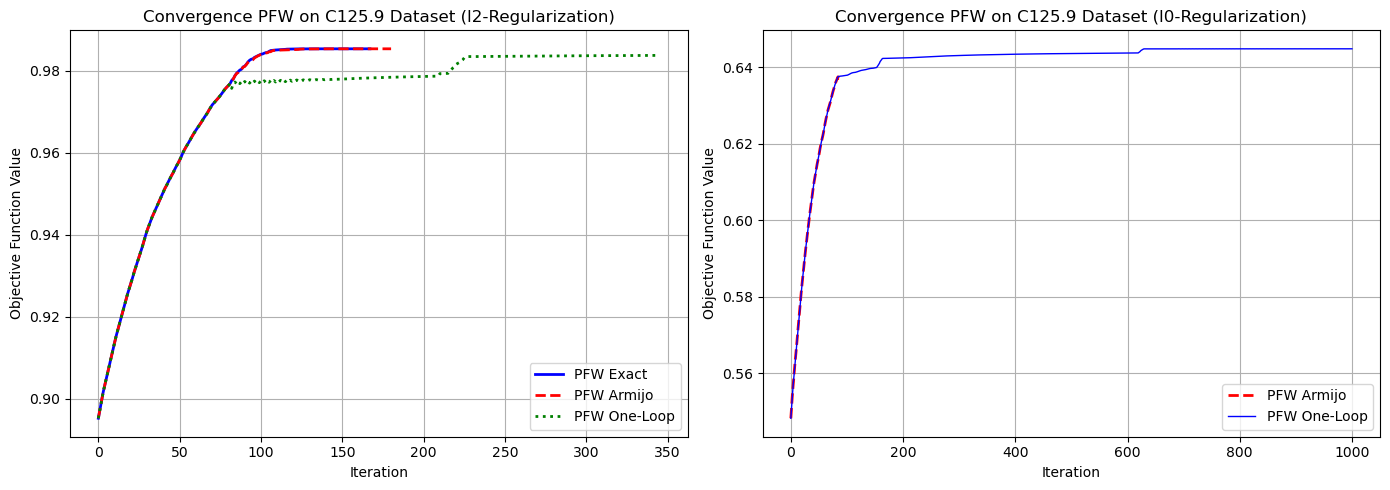

In [28]:
def plot_pfw_results(
    history_PFW_exact_l2, history_PFW_armijo_l2, history_PFW_log_l2,
    history_PFW_armijo_l0, history_PFW_log_l0, graph_name = None
):
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))  # 1 row, 2 columns

    # --- First subplot: l2-Regularization ---
    axes[0].plot(history_PFW_exact_l2, label='PFW Exact', color='blue', linewidth=2, linestyle='-')
    axes[0].plot(history_PFW_armijo_l2, label='PFW Armijo', color='red', linewidth=2, linestyle='--')
    axes[0].plot(history_PFW_log_l2, label='PFW One-Loop', color='green', linewidth=2, linestyle=':')
    axes[0].set_xlabel("Iteration")
    axes[0].set_ylabel("Objective Function Value")
    axes[0].set_title(f"Convergence PFW on {graph_name} Dataset (l2-Regularization)")
    axes[0].legend()
    axes[0].grid(True)

    # --- Second subplot: l0-Regularization ---
    axes[1].plot(history_PFW_armijo_l0, label='PFW Armijo', color='red', linewidth=2, linestyle='--')
    axes[1].plot(history_PFW_log_l0, label='PFW One-Loop', color='blue', linewidth=1, linestyle='-')
    axes[1].set_xlabel("Iteration")
    axes[1].set_ylabel("Objective Function Value")
    axes[1].set_title(f"Convergence PFW on {graph_name} Dataset (l0-Regularization)")
    axes[1].legend()
    axes[1].grid(True)

    plt.tight_layout()
    plt.show()

plot_pfw_results(
    history_PFW_exact_l2_A1, history_PFW_armijo_l2_A1, history_PFW_log_l2_A1,
    history_PFW_armijo_l0_A1, history_PFW_log_l0_A1, graph_name='C125.9'
)

## Tests on Dataset 2

In [29]:
# FW on l2-regularized objective function
# with exact line search
x_opt_FW_exact_l2_A2, history_FW_exact_l2_A2 = frank_wolfe(obj_l2, grad_l2, A2, num_iters=1000, line_search= 'exact', verbose = False)
clique_FW_exact_l2_A2, size_clique_FW_exact_l2_A2 = extract_clique_from_solution(x_opt_FW_exact_l2_A2, A2)

# with Armijo line search
x_opt_FW_armijo_l2_A2, history_FW_armijo_l2_A2 = frank_wolfe(obj_l2, grad_l2, A2, num_iters=1000, line_search= 'armijo', verbose = False)
clique_FW_armijo_l2_A2, size_clique_FW_armijo_l2_A2 = extract_clique_from_solution(x_opt_FW_armijo_l2_A2, A2)

# with One-Loop line search
x_opt_FW_log_l2_A2, history_FW_log_l2_A2 = frank_wolfe(obj_l2, grad_l2, A2, num_iters=1000, line_search='log', verbose = False)
clique_FW_log_l2_A2, size_clique_FW_log_l2_A2 = extract_clique_from_solution(x_opt_FW_log_l2_A2, A2)

# FW on l0-regularized objective function
# with Armijo line search
x_opt_FW_armijo_l0_A2, history_FW_armijo_l0_A2 = frank_wolfe(obj_l0, grad_l0, A2, num_iters=1000, line_search= 'armijo', verbose = False)
clique_FW_armijo_l0_A2, size_clique_FW_armijo_l0_A2 = extract_clique_from_solution(x_opt_FW_armijo_l0_A2, A2)

# with Deminishing step size
x_opt_FW_demin_l0_A2, history_FW_demin_l0_A2 = frank_wolfe(obj_l0, grad_l0, A2, num_iters=1000, line_search= 'demin', verbose = False)
clique_FW_demin_l0_A2, size_clique_FW_demin_l0_A2 = extract_clique_from_solution(x_opt_FW_demin_l0_A2, A2)

# with One-Loop line search
x_opt_FW_log_l0_A2, history_FW_log_l0_A2 = frank_wolfe(obj_l0, grad_l0, A2, num_iters=1000, line_search= 'log', verbose = False)
clique_FW_log_l0_A2, size_clique_FW_log_l0_A2 = extract_clique_from_solution(x_opt_FW_log_l0_A2, A2)


# ASFW on l2-regularized objective function
# with exact line search
x_opt_ASFW_exact_l2_A2, history_ASFW_exact_l2_A2 = away_step_frank_wolfe(obj_l2, grad_l2, A2, num_iters=1000, line_search= 'exact', verbose = False)
clique_ASFW_exact_l2_A2, size_clique_ASFW_exact_l2_A2 = extract_clique_from_solution(x_opt_ASFW_exact_l2_A2, A2)

# with Armijo line search
x_opt_ASFW_armijo_l2_A2, history_ASFW_armijo_l2_A2 = away_step_frank_wolfe(obj_l2, grad_l2, A2, num_iters=1000, line_search='armijo', verbose = False)
clique_ASFW_armijo_l2_A2, size_clique_ASFW_armijo_l2_A2 = extract_clique_from_solution(x_opt_ASFW_armijo_l2_A2, A2)

# with One-Loop line search
x_opt_ASFW_log_l2_A2, history_ASFW_log_l2_A2 = away_step_frank_wolfe(obj_l2, grad_l2, A2, num_iters=1000, line_search='log', verbose = False) 
clique_ASFW_log_l2_A2, size_clique_ASFW_log_l2_A2 = extract_clique_from_solution(x_opt_ASFW_log_l2_A2, A2)


# ASFW on l0-regularized objective function
# with Armijo line search
x_opt_ASFW_armijo_l0_A2, history_ASFW_armijo_l0_A2 = away_step_frank_wolfe(obj_l0, grad_l0, A2, num_iters=1000, line_search='armijo', verbose = False)
clique_ASFW_armijo_l0_A2, size_clique_ASFW_armijo_l0_A2 = extract_clique_from_solution(x_opt_ASFW_armijo_l0_A2, A2)

# with One-Loop line search
x_opt_ASFW_log_l0_A2, history_ASFW_log_l0_A2 = away_step_frank_wolfe(obj_l0, grad_l0, A2, num_iters=1000, line_search='log', verbose = False)
clique_ASFW_log_l0_A2, size_clique_ASFW_log_l0_A2 = extract_clique_from_solution(x_opt_ASFW_log_l0_A2, A2)


# PFW on l2-regularized objective function
# with exact line search
x_opt_PFW_exact_l2_A2, history_PFW_exact_l2_A2 = pairwise_frank_wolfe(obj_l2, grad_l2, A2, num_iters=1000, line_search='exact', verbose = False)
clique_PFW_exact_l2_A2, size_clique_PFW_exact_l2_A2 = extract_clique_from_solution(x_opt_PFW_exact_l2_A2, A2)

# with Armijo line search
x_opt_PFW_armijo_l2_A2, history_PFW_armijo_l2_A2 = pairwise_frank_wolfe(obj_l2, grad_l2, A2, num_iters=1000, line_search='armijo', verbose = False)    
clique_PFW_armijo_l2_A2, size_clique_PFW_armijo_l2_A2 = extract_clique_from_solution(x_opt_PFW_armijo_l2_A2, A2)

# with One-Loop line search
x_opt_PFW_log_l2_A2, history_PFW_log_l2_A2 = pairwise_frank_wolfe(obj_l2, grad_l2, A2, num_iters=1000, line_search='log', verbose = False)
clique_PFW_log_l2_A2, size_clique_PFW_log_l2_A2 = extract_clique_from_solution(x_opt_PFW_log_l2_A2, A2)

# PFW on l0-regularized objective function
# with Armijo line search
x_opt_PFW_armijo_l0_A2, history_PFW_armijo_l0_A2 = pairwise_frank_wolfe(obj_l0, grad_l0, A2, num_iters=1000, line_search='armijo', verbose = False)
clique_PFW_armijo_l0_A2, size_clique_PFW_armijo_l0_A2 = extract_clique_from_solution(x_opt_PFW_armijo_l0_A2, A2)

# with One-Loop line search
x_opt_PFW_log_l0_A2, history_PFW_log_l0_A2 = pairwise_frank_wolfe(obj_l0, grad_l0, A2, num_iters=1000, line_search='log', verbose = False)
clique_PFW_log_l0_A2, size_clique_PFW_log_l0_A2 = extract_clique_from_solution(x_opt_PFW_log_l0_A2, A2)

Converged at iteration 690, relative update = 9.97e-07
Converged at iteration 302, relative update = 8.89e-07
Converged at iteration 558, relative update = 9.96e-07
Converged at iteration 201, relative update = 8.24e-07
Converged at iteration 139, relative update = 9.98e-07
Converged at iteration 428, relative update = 9.96e-07


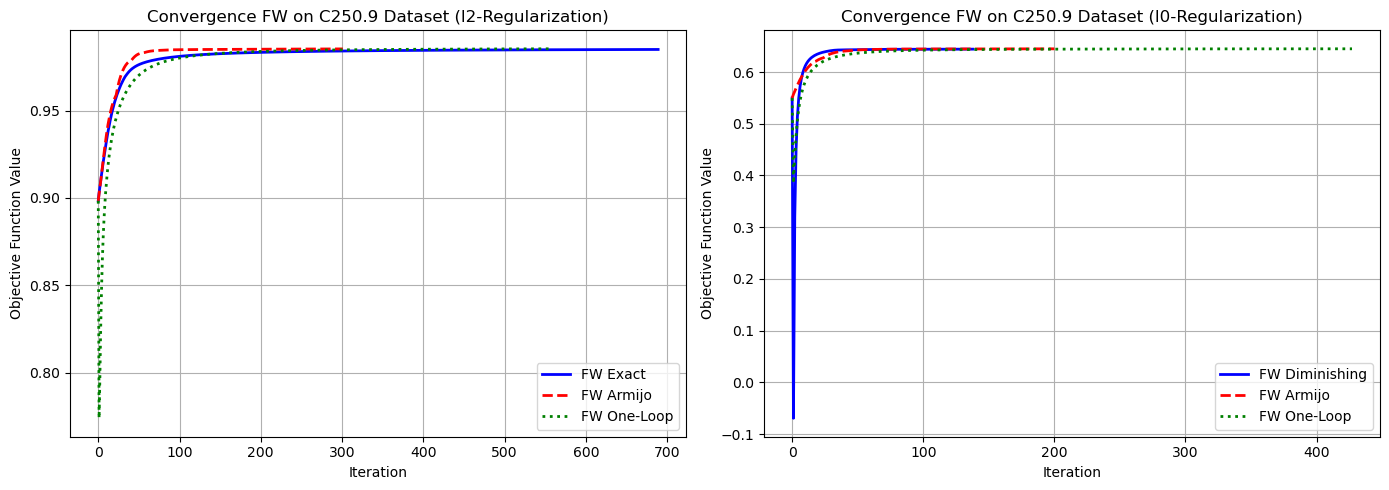

In [30]:
plot_fw_results(
    history_FW_exact_l2_A2, history_FW_armijo_l2_A2, history_FW_log_l2_A2,
    history_FW_armijo_l0_A2, history_FW_demin_l0_A2, history_FW_log_l0_A2, graph_name='C250.9'
)

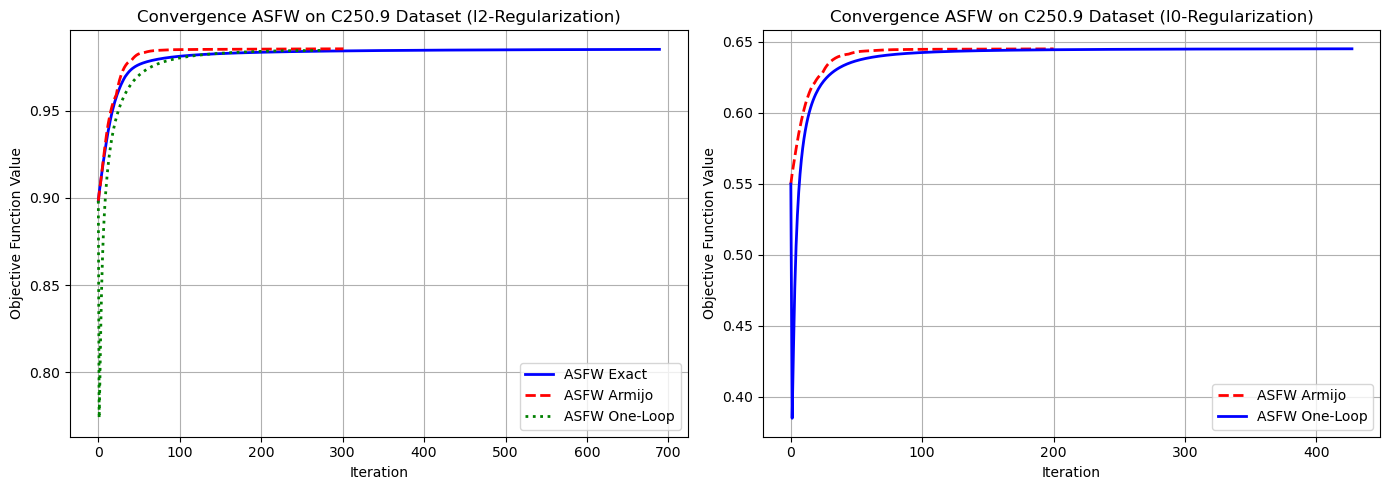

In [31]:
plot_asfw_results(
    history_ASFW_exact_l2_A2, history_ASFW_armijo_l2_A2, history_ASFW_log_l2_A2,
    history_ASFW_armijo_l0_A2, history_ASFW_log_l0_A2, graph_name= 'C250.9'
)

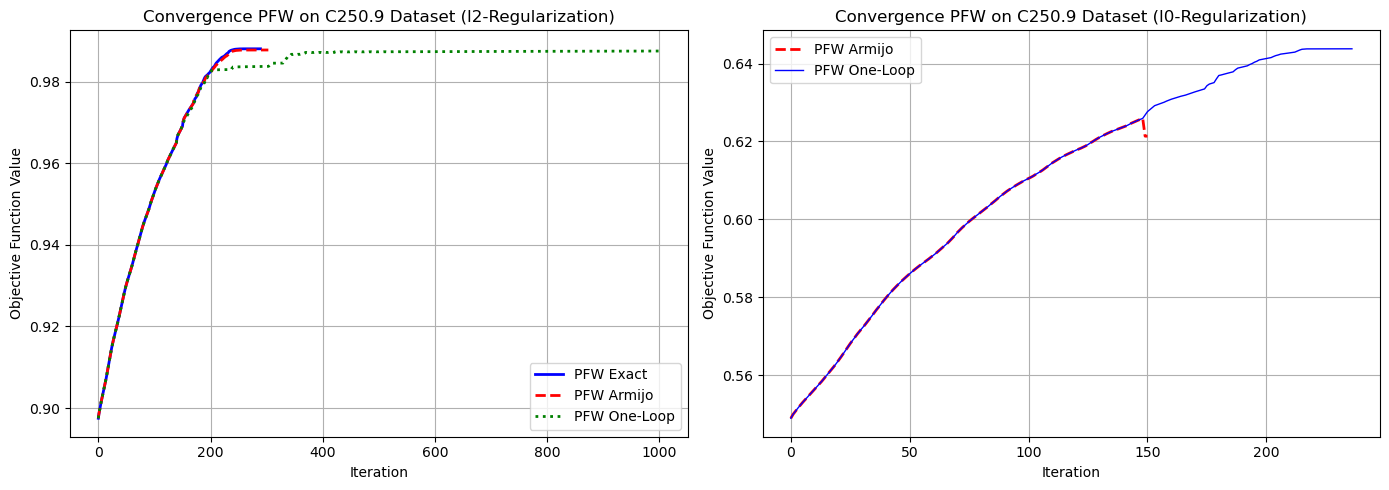

In [32]:
plot_pfw_results(
    history_PFW_exact_l2_A2, history_PFW_armijo_l2_A2, history_PFW_log_l2_A2,
    history_PFW_armijo_l0_A2, history_PFW_log_l0_A2, graph_name='C250.9'
)

## Tests on Dataset 3

In [33]:
# FW on l2-regularized objective function
# with exact line search
x_opt_FW_exact_l2_A3, history_FW_exact_l2_A3 = frank_wolfe(obj_l2, grad_l2, A3, num_iters=1000, line_search= 'exact', verbose = False)
clique_FW_exact_l2_A3, size_clique_FW_exact_l2_A3 = extract_clique_from_solution(x_opt_FW_exact_l2_A3, A3)

# with Armijo line search
x_opt_FW_armijo_l2_A3, history_FW_armijo_l2_A3 = frank_wolfe(obj_l2, grad_l2, A3, num_iters=1000, line_search= 'armijo', verbose = False)
clique_FW_armijo_l2_A3, size_clique_FW_armijo_l2_A3 = extract_clique_from_solution(x_opt_FW_armijo_l2_A3, A3)

# with One-Loop line search
x_opt_FW_log_l2_A3, history_FW_log_l2_A3 = frank_wolfe(obj_l2, grad_l2, A3, num_iters=1000, line_search='log', verbose = False)
clique_FW_log_l2_A3, size_clique_FW_log_l2_A3 = extract_clique_from_solution(x_opt_FW_log_l2_A3, A3)

# FW on l0-regularized objective function
# with Armijo line search
x_opt_FW_armijo_l0_A3, history_FW_armijo_l0_A3 = frank_wolfe(obj_l0, grad_l0, A3, num_iters=1000, line_search= 'armijo', verbose = False)
clique_FW_armijo_l0_A3, size_clique_FW_armijo_l0_A3 = extract_clique_from_solution(x_opt_FW_armijo_l0_A3, A3)

# with Deminishing step size
x_opt_FW_demin_l0_A3, history_FW_demin_l0_A3 = frank_wolfe(obj_l0, grad_l0, A3, num_iters=1000, line_search= 'demin', verbose = False)
clique_FW_demin_l0_A3, size_clique_FW_demin_l0_A3 = extract_clique_from_solution(x_opt_FW_demin_l0_A3, A3)

# with One-Loop line search
x_opt_FW_log_l0_A3, history_FW_log_l0_A3 = frank_wolfe(obj_l0, grad_l0, A3, num_iters=1000, line_search= 'log', verbose = False)
clique_FW_log_l0_A3, size_clique_FW_log_l0_A3 = extract_clique_from_solution(x_opt_FW_log_l0_A3, A3)


# ASFW on l2-regularized objective function
# with exact line search
x_opt_ASFW_exact_l2_A3, history_ASFW_exact_l2_A3 = away_step_frank_wolfe(obj_l2, grad_l2, A3, num_iters=1000, line_search= 'exact', verbose = False)
clique_ASFW_exact_l2_A3, size_clique_ASFW_exact_l2_A3 = extract_clique_from_solution(x_opt_ASFW_exact_l2_A3, A3)

# with Armijo line search
x_opt_ASFW_armijo_l2_A3, history_ASFW_armijo_l2_A3 = away_step_frank_wolfe(obj_l2, grad_l2, A3, num_iters=1000, line_search='armijo', verbose = False)
clique_ASFW_armijo_l2_A3, size_clique_ASFW_armijo_l2_A3 = extract_clique_from_solution(x_opt_ASFW_armijo_l2_A3, A3)

# with One-Loop line search
x_opt_ASFW_log_l2_A3, history_ASFW_log_l2_A3 = away_step_frank_wolfe(obj_l2, grad_l2, A3, num_iters=1000, line_search='log', verbose = False) 
clique_ASFW_log_l2_A3, size_clique_ASFW_log_l2_A3 = extract_clique_from_solution(x_opt_ASFW_log_l2_A3, A3)


# ASFW on l0-regularized objective function
# with Armijo line search
x_opt_ASFW_armijo_l0_A3, history_ASFW_armijo_l0_A3 = away_step_frank_wolfe(obj_l0, grad_l0, A3, num_iters=1000, line_search='armijo', verbose = False)
clique_ASFW_armijo_l0_A3, size_clique_ASFW_armijo_l0_A3 = extract_clique_from_solution(x_opt_ASFW_armijo_l0_A3, A3)

# with One-Loop line search
x_opt_ASFW_log_l0_A3, history_ASFW_log_l0_A3 = away_step_frank_wolfe(obj_l0, grad_l0, A3, num_iters=1000, line_search='log', verbose = False)
clique_ASFW_log_l0_A3, size_clique_ASFW_log_l0_A3 = extract_clique_from_solution(x_opt_ASFW_log_l0_A3, A3)


# PFW on l2-regularized objective function
# with exact line search
x_opt_PFW_exact_l2_A3, history_PFW_exact_l2_A3 = pairwise_frank_wolfe(obj_l2, grad_l2, A3, num_iters=1000, line_search='exact', verbose = False)
clique_PFW_exact_l2_A3, size_clique_PFW_exact_l2_A3 = extract_clique_from_solution(x_opt_PFW_exact_l2_A3, A3)

# with Armijo line search
x_opt_PFW_armijo_l2_A3, history_PFW_armijo_l2_A3 = pairwise_frank_wolfe(obj_l2, grad_l2, A3, num_iters=1000, line_search='armijo', verbose = False)    
clique_PFW_armijo_l2_A3, size_clique_PFW_armijo_l2_A3 = extract_clique_from_solution(x_opt_PFW_armijo_l2_A3, A3)

# with One-Loop line search
x_opt_PFW_log_l2_A3, history_PFW_log_l2_A3 = pairwise_frank_wolfe(obj_l2, grad_l2, A3, num_iters=1000, line_search='log', verbose = False)
clique_PFW_log_l2_A3, size_clique_PFW_log_l2_A3 = extract_clique_from_solution(x_opt_PFW_log_l2_A3, A3)

# PFW on l0-regularized objective function
# with Armijo line search
x_opt_PFW_armijo_l0_A3, history_PFW_armijo_l0_A3 = pairwise_frank_wolfe(obj_l0, grad_l0, A3, num_iters=1000, line_search='armijo', verbose = False)
clique_PFW_armijo_l0_A3, size_clique_PFW_armijo_l0_A3 = extract_clique_from_solution(x_opt_PFW_armijo_l0_A3, A3)

# with One-Loop line search
x_opt_PFW_log_l0_A3, history_PFW_log_l0_A3 = pairwise_frank_wolfe(obj_l0, grad_l0, A3, num_iters=1000, line_search='log', verbose = False)
clique_PFW_log_l0_A3, size_clique_PFW_log_l0_A3 = extract_clique_from_solution(x_opt_PFW_log_l0_A3, A3)

Converged at iteration 654, relative update = 9.98e-07
Converged at iteration 322, relative update = 9.93e-07
Converged at iteration 306, relative update = 9.98e-07
Converged at iteration 266, relative update = 9.93e-07
Converged at iteration 116, relative update = 8.42e-07
Converged at iteration 322, relative update = 9.96e-07


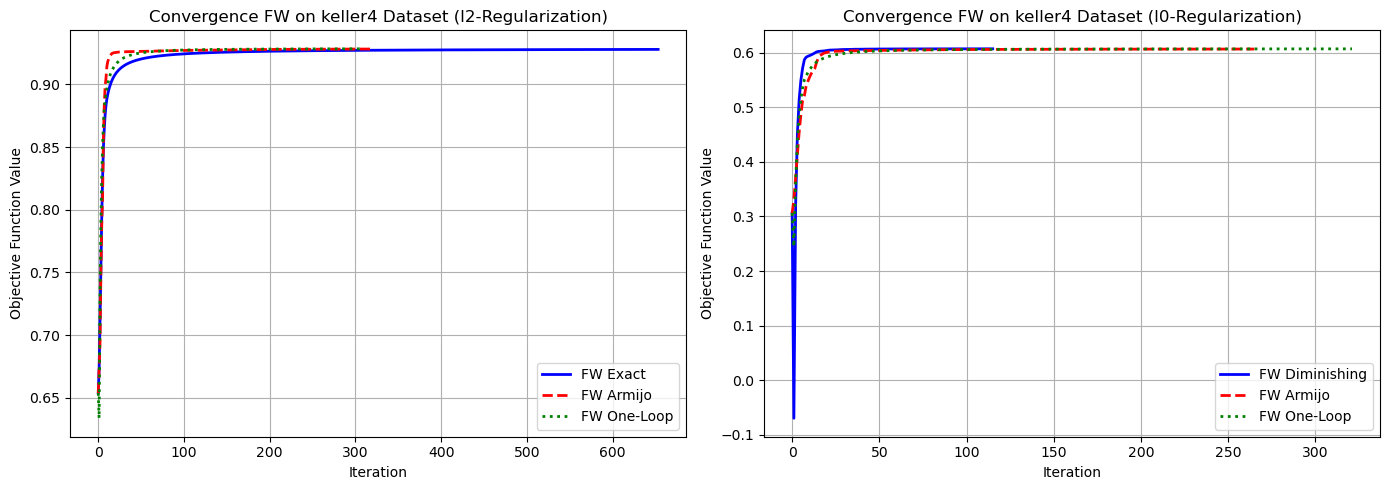

In [34]:
plot_fw_results(
    history_FW_exact_l2_A3, history_FW_armijo_l2_A3, history_FW_log_l2_A3,
    history_FW_armijo_l0_A3, history_FW_demin_l0_A3, history_FW_log_l0_A3, graph_name='keller4'
)

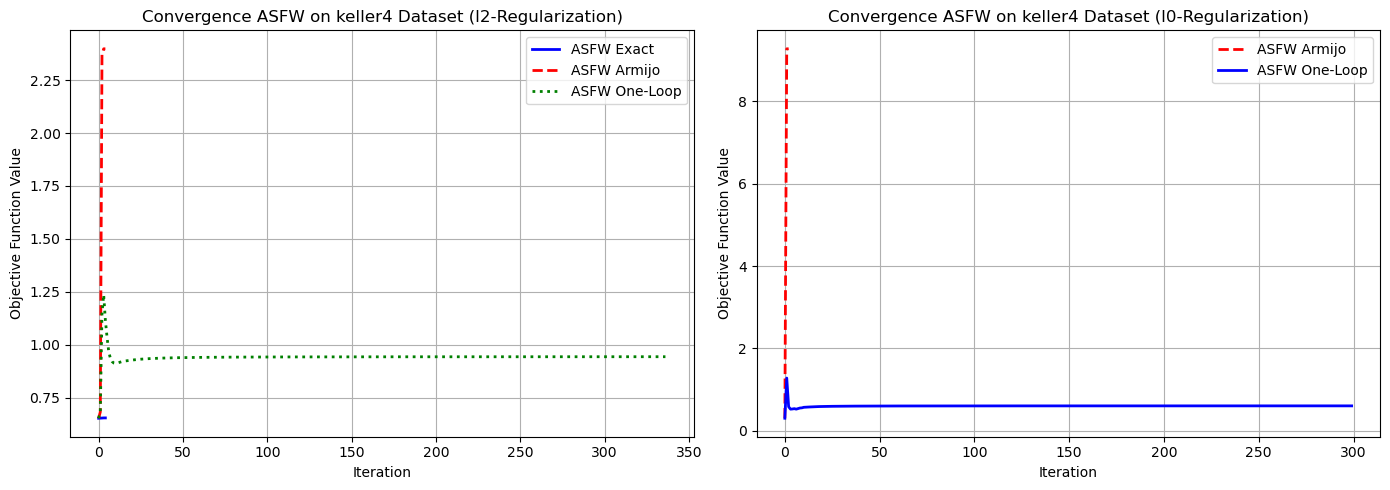

In [35]:
plot_asfw_results(
    history_ASFW_exact_l2_A3, history_ASFW_armijo_l2_A3, history_ASFW_log_l2_A3,
    history_ASFW_armijo_l0_A3, history_ASFW_log_l0_A3, graph_name= 'keller4'
)

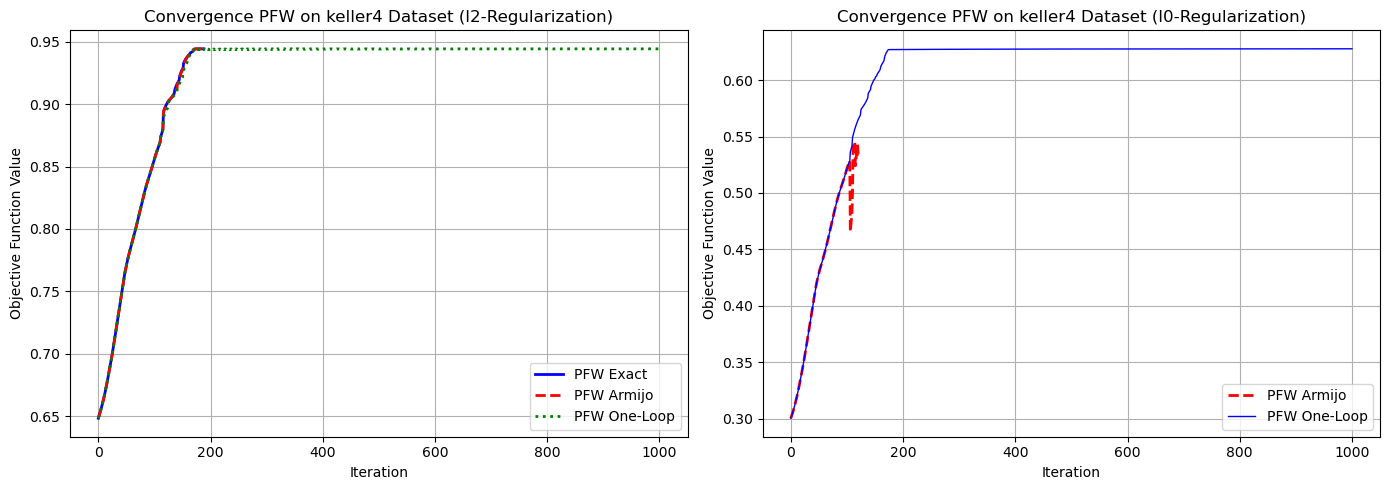

In [36]:
plot_pfw_results(
    history_PFW_exact_l2_A3, history_PFW_armijo_l2_A3, history_PFW_log_l2_A3,
    history_PFW_armijo_l0_A3, history_PFW_log_l0_A3, graph_name='keller4'
)

In [37]:

def plot_clique_sizes(
    size_FW_exact_l2_A, size_FW_armijo_l2_A, size_FW_log_l2_A,
    size_ASFW_exact_l2_A, size_ASFW_armijo_l2_A, size_ASFW_log_l2_A,
    size_PFW_exact_l2_A, size_PFW_armijo_l2_A, size_PFW_log_l2_A,
    size_FW_armijo_l0_A, size_FW_demin_l0_A, size_FW_log_l0_A,
    size_ASFW_armijo_l0_A, size_ASFW_log_l0_A,
    size_PFW_armijo_l0_A, size_PFW_log_l0_A
):
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))

    # ================= l2-Regularization =================
    algos_l2 = ["FW", "ASFW", "PFW"]
    strategies_l2 = ["Exact", "Armijo", "One-Loop"]
    values_l2 = [
        [size_FW_exact_l2_A, size_FW_armijo_l2_A, size_FW_log_l2_A],
        [size_ASFW_exact_l2_A, size_ASFW_armijo_l2_A, size_ASFW_log_l2_A],
        [size_PFW_exact_l2_A, size_PFW_armijo_l2_A, size_PFW_log_l2_A]
    ]

    x = np.arange(len(algos_l2))
    width = 0.25
    for i, strat in enumerate(strategies_l2):
        axes[0].bar(x + i*width, [v[i] for v in values_l2], width, label=strat)

    axes[0].set_xticks(x + width)
    axes[0].set_xticklabels(algos_l2)
    axes[0].set_ylabel("Clique Size")
    axes[0].set_title("Clique Sizes (l2-Regularization)")
    axes[0].legend()
    axes[0].grid(axis="y", linestyle="--", alpha=0.7)

    # ================= l0-Regularization =================
    algos_l0 = ["FW", "ASFW", "PFW"]
    strategies_l0 = ["Armijo", "Demin", "One-Loop"]
    values_l0 = [
        [size_FW_armijo_l0_A, size_FW_demin_l0_A, size_FW_log_l0_A],
        [size_ASFW_armijo_l0_A, None, size_ASFW_log_l0_A],
        [size_PFW_armijo_l0_A, None, size_PFW_log_l0_A]
    ]

    x = np.arange(len(algos_l0))
    width = 0.25
    for i, strat in enumerate(strategies_l0):
        bar_values = [v[i] if v[i] is not None else 0 for v in values_l0]
        axes[1].bar(x + i*width, bar_values, width, label=strat)

    axes[1].set_xticks(x + width)
    axes[1].set_xticklabels(algos_l0)
    axes[1].set_ylabel("Clique Size")
    axes[1].set_title("Clique Sizes (l0-Regularization)")
    axes[1].legend()
    axes[1].grid(axis="y", linestyle="--", alpha=0.7)

    plt.tight_layout()
    plt.show()


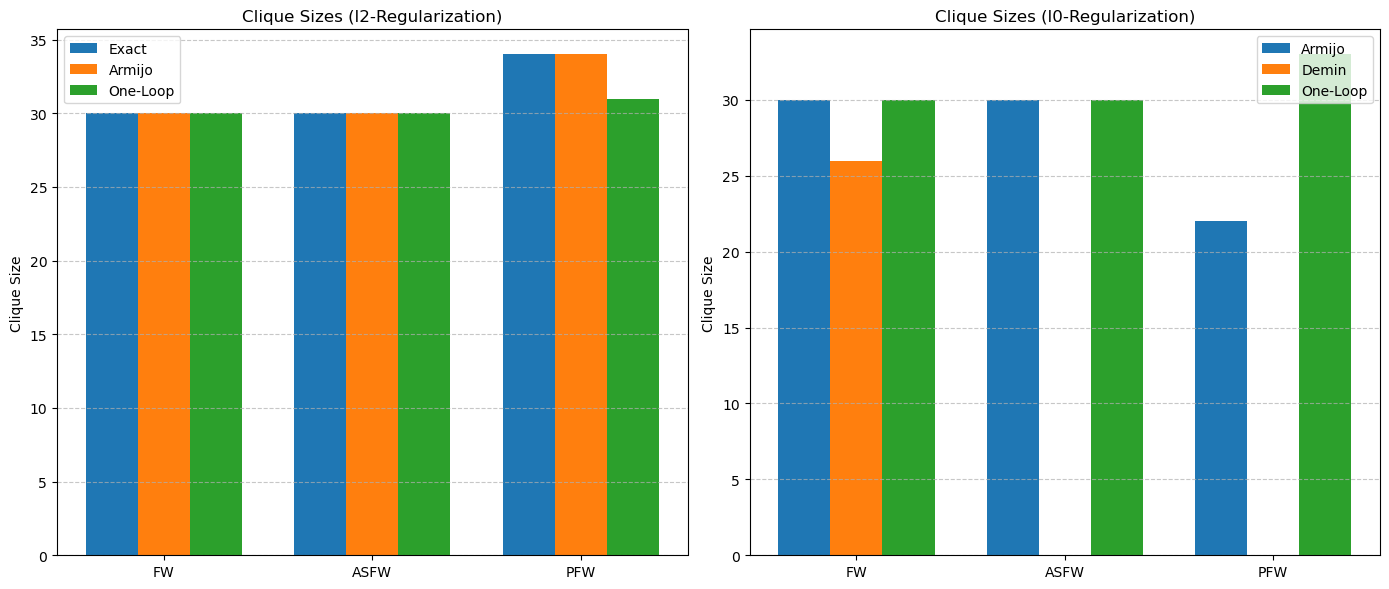

In [38]:
plot_clique_sizes(
    size_clique_FW_exact_l2_A1, size_clique_FW_armijo_l2_A1, size_clique_FW_log_l2_A1,
    size_clique_ASFW_exact_l2_A1, size_clique_ASFW_armijo_l2_A1, size_clique_ASFW_log_l2_A1,
    size_clique_PFW_exact_l2_A1, size_clique_PFW_armijo_l2_A1, size_clique_PFW_log_l2_A1,
    size_clique_FW_armijo_l0_A1, size_clique_FW_demin_l0_A1, size_clique_FW_log_l0_A1,
    size_clique_ASFW_armijo_l0_A1, size_clique_ASFW_log_l0_A1,
    size_clique_PFW_armijo_l0_A1, size_clique_PFW_log_l0_A1
)

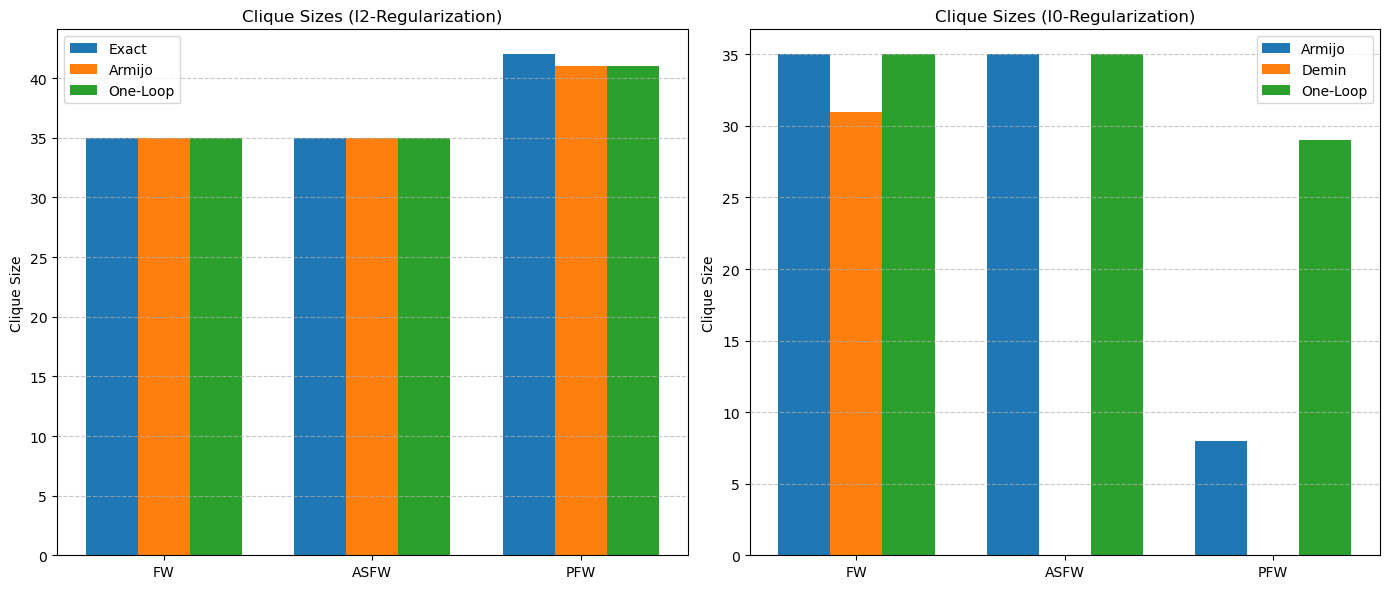

In [39]:
plot_clique_sizes(
    size_clique_FW_exact_l2_A2, size_clique_FW_armijo_l2_A2, size_clique_FW_log_l2_A2,
    size_clique_ASFW_exact_l2_A2, size_clique_ASFW_armijo_l2_A2, size_clique_ASFW_log_l2_A2,
    size_clique_PFW_exact_l2_A2, size_clique_PFW_armijo_l2_A2, size_clique_PFW_log_l2_A2,
    size_clique_FW_armijo_l0_A2, size_clique_FW_demin_l0_A2, size_clique_FW_log_l0_A2,
    size_clique_ASFW_armijo_l0_A2, size_clique_ASFW_log_l0_A2,
    size_clique_PFW_armijo_l0_A2, size_clique_PFW_log_l0_A2
)


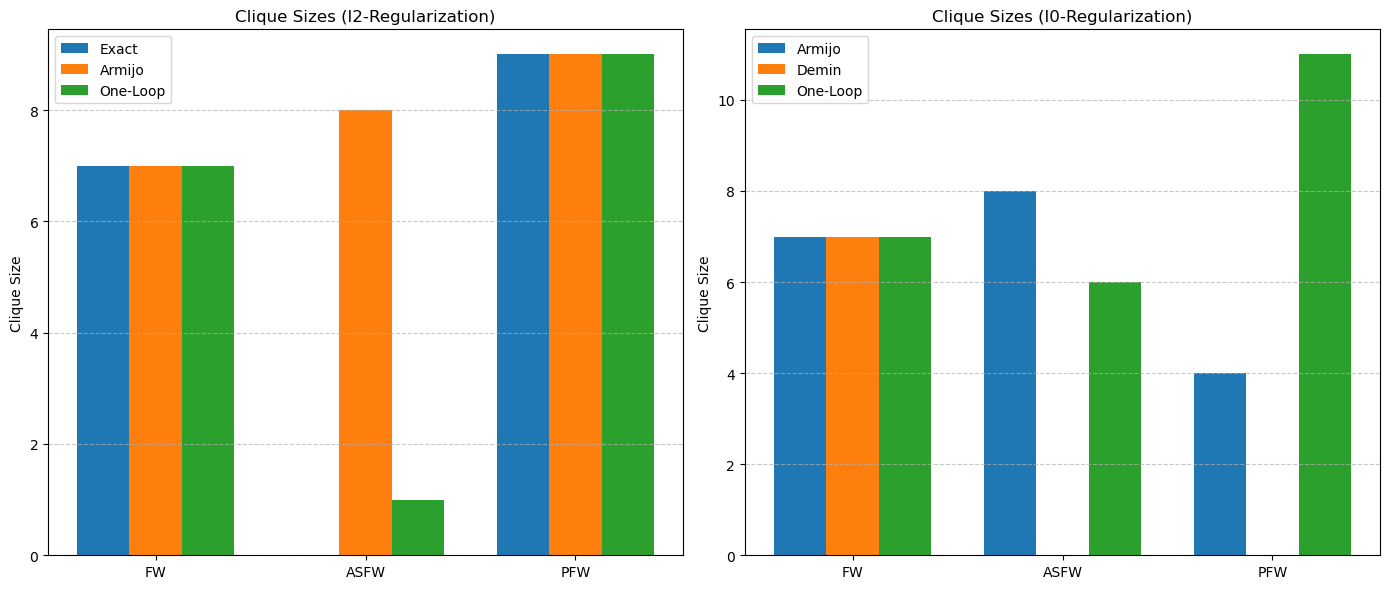

In [40]:
plot_clique_sizes(
    size_clique_FW_exact_l2_A3, size_clique_FW_armijo_l2_A3, size_clique_FW_log_l2_A3,
    size_clique_ASFW_exact_l2_A3, size_clique_ASFW_armijo_l2_A3, size_clique_ASFW_log_l2_A3,
    size_clique_PFW_exact_l2_A3, size_clique_PFW_armijo_l2_A3, size_clique_PFW_log_l2_A3,
    size_clique_FW_armijo_l0_A3, size_clique_FW_demin_l0_A3, size_clique_FW_log_l0_A3,
    size_clique_ASFW_armijo_l0_A3, size_clique_ASFW_log_l0_A3,
    size_clique_PFW_armijo_l0_A3, size_clique_PFW_log_l0_A3
)

## Projected Gradient Method

In [41]:
# Simplex projection for projected gradient
def proj_simplex(v):
    v_sorted = np.sort(v)[::-1]
    cssv = np.cumsum(v_sorted)
    rho = np.where(v_sorted + (1 - cssv) / (np.arange(len(v)) + 1) > 0)[0][-1]
    theta = (cssv[rho] - 1) / (rho + 1)
    return np.maximum(v - theta, 0)

In [ ]:
def projected_gradient(obj_func, grad_obj_func, proj, A, num_iters=100, line_search='demin', tol=1e-6, verbose=True, **kwargs):
    n = A.shape[0]
    x = np.ones(n) / n

    
    history = [float(obj_func(x, A, **kwargs))]
    x_best = np.copy(x)
    f_best = history[0]
    
    for it in range(num_iters):
        grad = grad_obj_func(x, A, **kwargs)
        d = grad  
        
        # Step size
        if line_search == 'armijo':
            step = armijo_line_search(obj_func, x, grad, d, A, initial_step=1.0, **kwargs)
        elif line_search == 'demin':
            step = min(2 / (it + 2), 1.0)
        elif line_search == 'log':
            step = log_adaptive_step_size(it + 1)
 
        
        x_next = proj(x + step * d)
        
        if np.linalg.norm(x_next - x) < tol:
            if verbose:
                print(f"Converged at iteration {it+1}, relative update = {np.linalg.norm(x_next - x):.2e}")
            x = x_next
            break
        
        x = x_next
        current_f = float(obj_func(x, A, **kwargs))
        history.append(current_f)
        
        if current_f > f_best:
            f_best = current_f
            x_best = np.copy(x)
        
        if verbose and (it % 10 == 0 or it == num_iters - 1):
            print(f"Iter {it+1:3d}: f(x) = {current_f:.6f}, step = {step:.4f}")
    
    return x_best, history


### Comparison bw FW and Projected Method

In [76]:
B1 = load_dimacs_graph("graphs/brock200_4.clq")
B2 = load_dimacs_graph("graphs/C2000.9.clq")
alpha = 0.5

print(f"Graph with nodes: {B1.shape[0]}")
print(f"Graph with nodes: {B2.shape[0]}")

Graph with nodes: 200
Graph with nodes: 2000


Iter  11: f(x) = 0.906727, step = 0.2896
Iter  21: f(x) = 0.934567, step = 0.1951
Iter  31: f(x) = 0.943125, step = 0.1499
Iter  41: f(x) = 0.947023, step = 0.1228
Iter  51: f(x) = 0.949162, step = 0.1045
Iter  61: f(x) = 0.950476, step = 0.0913
Iter  71: f(x) = 0.951346, step = 0.0812
Iter  81: f(x) = 0.951955, step = 0.0733
Iter  91: f(x) = 0.952399, step = 0.0669
Iter 101: f(x) = 0.952734, step = 0.0616
Iter 111: f(x) = 0.952994, step = 0.0571
Iter 121: f(x) = 0.953199, step = 0.0532
Iter 131: f(x) = 0.953365, step = 0.0499
Iter 141: f(x) = 0.953501, step = 0.0470
Iter 151: f(x) = 0.953613, step = 0.0444
Iter 161: f(x) = 0.953708, step = 0.0422
Iter 171: f(x) = 0.953789, step = 0.0401
Iter 181: f(x) = 0.953858, step = 0.0383
Iter 191: f(x) = 0.953917, step = 0.0366
Iter 201: f(x) = 0.953969, step = 0.0351
Iter 211: f(x) = 0.954014, step = 0.0337
Iter 221: f(x) = 0.954055, step = 0.0324
Iter 231: f(x) = 0.954090, step = 0.0312
Iter 241: f(x) = 0.954122, step = 0.0301
Iter 251: f(x) =

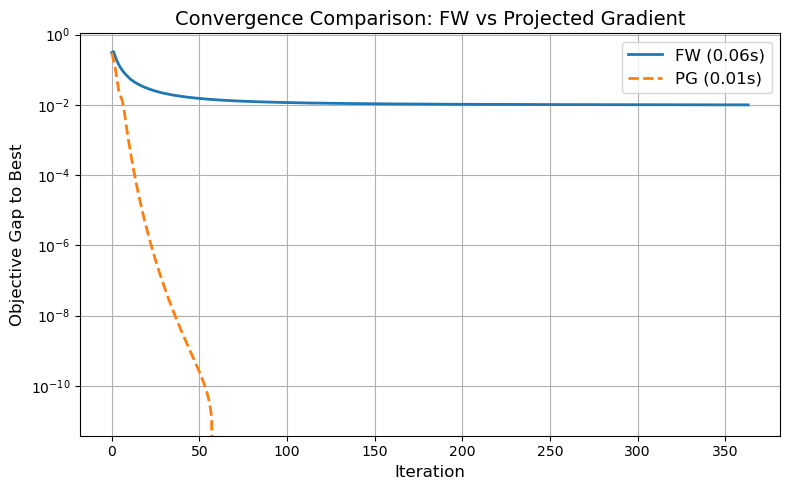

In [ ]:
num_iters = 1000

# Frank-Wolfe
start_fw = time.time()
x_fw, hist_fw = frank_wolfe(obj_func=obj_l2, grad_obj_func=grad_l2, A=B1,
                             num_iters=num_iters, line_search='log', verbose=True)
time_fw = time.time() - start_fw
clique_fw, size_clique_fw = extract_clique_from_solution(x_fw, B1)
n = B1.shape[0]

# Projected Gradient
start_pg = time.time()
x_pg, hist_pg = projected_gradient(obj_func=obj_l2, grad_obj_func=grad_l2, proj=proj_simplex,
                                   A=B1, num_iters=num_iters, line_search='log', verbose=True)
time_pg = time.time() - start_pg
clique_pg, size_clique_pg = extract_clique_from_solution(x_pg, B1)

print("Algorithm Comparison Results".center(60, "="))
print(f"{'Algorithm':<20}{'Max Clique Size':<20}{'Time (s)':<10}{'Time/O(n)':<10}")
print(f"{'-'*60}")
print(f"{'Frank-Wolfe':<20}{size_clique_fw:<20}{time_fw:<10.4f}{time_fw/n:<10.5f}")
print(f"{'Projected Gradient':<20}{size_clique_pg:<20}{time_pg:<10.4f}{time_pg/n:<10.5f}")
print("="*60)

# Plot convergence (objective difference from best)
best_obj = max(max(hist_fw), max(hist_pg))
plt.figure(figsize=(8,5))
plt.plot([best_obj - f for f in hist_fw], label=f'FW ({time_fw:.2f}s)', linewidth=2)
plt.plot([best_obj - f for f in hist_pg], '--', label=f'PG ({time_pg:.2f}s)', linewidth=2)
plt.yscale('log')
plt.xlabel('Iteration', fontsize=12)
plt.ylabel('Objective Gap to Best', fontsize=12)
plt.title('Convergence Comparison: FW vs Projected Gradient', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()


Iter  11: f(x) = 0.919874, step = 0.1250
Iter  21: f(x) = 0.950157, step = 0.1250
Iter  31: f(x) = 0.966423, step = 0.0625
Iter  41: f(x) = 0.977543, step = 0.0625
Iter  51: f(x) = 0.981278, step = 0.0625
Iter  61: f(x) = 0.985948, step = 0.0312
Iter  71: f(x) = 0.988178, step = 0.0312
Iter  81: f(x) = 0.989286, step = 0.0156
Iter  91: f(x) = 0.989945, step = 0.0156
Iter 101: f(x) = 0.990243, step = 0.0078
Iter 111: f(x) = 0.990445, step = 0.0078
Iter 121: f(x) = 0.990529, step = 0.0078
Iter 131: f(x) = 0.990596, step = 0.0039
Iter 141: f(x) = 0.990646, step = 0.0039
Iter 151: f(x) = 0.990676, step = 0.0039
Converged at iteration 156, relative update = 8.77e-07
Iter   1: f(x) = 0.925030, step = 1.0000
Iter  11: f(x) = 0.921819, step = 1.0000
Iter  21: f(x) = 0.921819, step = 1.0000
Iter  31: f(x) = 0.921819, step = 1.0000
Iter  41: f(x) = 0.921819, step = 1.0000
Iter  51: f(x) = 0.921819, step = 1.0000
Iter  61: f(x) = 0.921819, step = 1.0000
Iter  71: f(x) = 0.921819, step = 1.0000
It

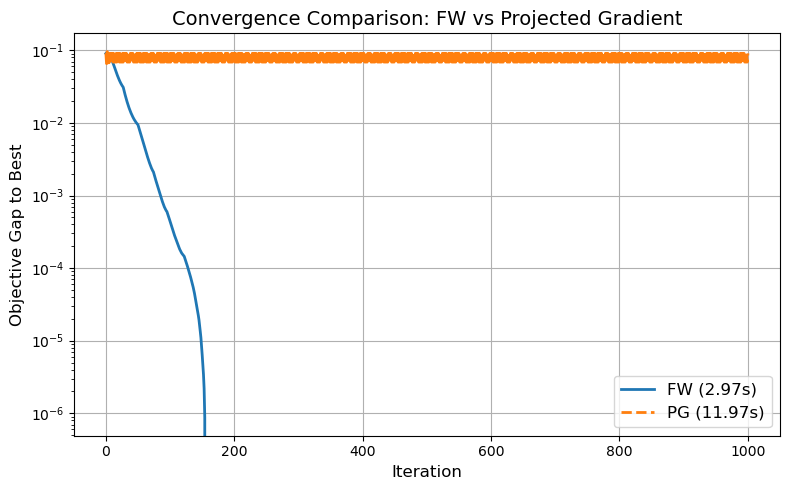

In [ ]:
num_iters = 1000

# Frank-Wolfe
start_fw = time.time()
x_fw, hist_fw = frank_wolfe(obj_func=obj_l2, grad_obj_func=grad_l2, A=B2,
                             num_iters=num_iters, line_search='armijo', verbose=True)
time_fw = time.time() - start_fw
clique_fw, size_clique_fw = extract_clique_from_solution(x_fw, B2)
n = B2.shape[0]

# Projected Gradient
start_pg = time.time()
x_pg, hist_pg = projected_gradient(obj_func=obj_l2, grad_obj_func=grad_l2, proj=proj_simplex,
                                   A=B2, num_iters=num_iters, line_search='armijo', verbose=True)
time_pg = time.time() - start_pg
clique_pg, size_clique_pg = extract_clique_from_solution(x_pg, B2)

print("Algorithm Comparison Results".center(60, "="))
print(f"{'Algorithm':<20}{'Max Clique Size':<20}{'Time (s)':<10}{'Time/O(n)':<10}")
print(f"{'-'*60}")
print(f"{'Frank-Wolfe':<20}{size_clique_fw:<20}{time_fw:<10.4f}{time_fw/n:<10.5f}")
print(f"{'Projected Gradient':<20}{size_clique_pg:<20}{time_pg:<10.4f}{time_pg/n:<10.5f}")
print("="*60)

# Plot convergence (objective difference from best)
best_obj = max(max(hist_fw), max(hist_pg))
plt.figure(figsize=(8,5))
plt.plot([best_obj - f for f in hist_fw], label=f'FW ({time_fw:.2f}s)', linewidth=2)
plt.plot([best_obj - f for f in hist_pg], '--', label=f'PG ({time_pg:.2f}s)', linewidth=2)
plt.yscale('log')
plt.xlabel('Iteration', fontsize=12)
plt.ylabel('Objective Gap to Best', fontsize=12)
plt.title('Convergence Comparison: FW vs Projected Gradient', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()
